# Finetuning a model on the Berkeley DeepDrive Dataset

In [1]:
# basic
import math
import os
import pickle
from PIL import Image
import random
import time

# data
import numpy as np
import pandas as pd

# plot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torch
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# vision reference. taken from https://github.com/pytorch/vision/tree/master/references/detection
from engine import train_one_epoch, evaluate
import utils

from dataset import BDDDataset

## Check GPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Config vars

In [3]:
root = '.'

dataset_path = os.path.join(root, 'dataset')
train_dataset_path = os.path.join(dataset_path, 'train')
val_dataset_path = os.path.join(dataset_path, 'val')
model_store_path = os.path.join(root, 'models')

# 10% used for val and 90% for train
val_split_ratio = 0.1

target_labels = ['car', 'traffic sign', 'pedestrian']
#target_labels = ['car']

# create a map for label->id
label_id_map = {}
id_label_map = {}
id_color_map = {}
colors = ['r', 'b', 'g']
for i in range(1, len(target_labels)+1):
    label_id_map[target_labels[i-1]] = i
    id_label_map[i] = target_labels[i-1]
    color = colors[i-1]
    id_color_map[i] = color
    
# bacbone model
#backbone_model = 'fasterrcnn_resnet50_fpn'
backbone_model = 'fasterrcnn_mobilenet_v3_large_fpn'

# training method. Set to false for manual training
use_coco_eval = True

## Utility functions

In [4]:
def plot_image_with_boxes(img, target):
    
    if torch.is_tensor(target['boxes']):
        target['boxes'] = target['boxes'].to('cpu').detach().numpy().tolist()
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img.permute(1, 2, 0))

    # draw each box
    for i in range(len(target['boxes'])):
        if int(target['labels'][i]) in id_label_map:
            bottom_left = (target['boxes'][i][0], target['boxes'][i][1])
            width = target['boxes'][i][2] - target['boxes'][i][0]
            height = target['boxes'][i][3] - target['boxes'][i][1]

            label = int(target['labels'][i])

            # Create a Rectangle patch
            rect = patches.Rectangle(bottom_left, width, height, linewidth=1,
                                     edgecolor=id_color_map[label], facecolor="none")

            # Add the patch to the Axes
            ax.add_patch(rect)
    plt.show()

In [5]:
def get_transform(train):
    
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    return transform

In [6]:
def get_fastrcnn_model(num_classes):

    # load the pretrained model
    if backbone_model == 'fasterrcnn_resnet50_fpn':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    elif backbone_model == 'fasterrcnn_mobilenet_v3_large_fpn':
        model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

    # number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace with pretrained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

## Testing the dataset

img shape: torch.Size([3, 720, 1280])
target: {'boxes': tensor([[1105.6692,  211.1221, 1170.7904,  233.5661],
        [  49.4448,  254.5304,  357.8058,  487.9062],
        [ 507.8275,  221.7275,  908.3676,  441.0052]]), 'labels': tensor([2, 1, 1]), 'image_id': tensor([0]), 'area': tensor([ 1461.5846, 71964.0312, 87829.5156]), 'iscrowd': tensor([0, 0, 0])}
dataset length: 1001


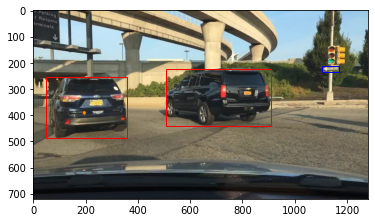

In [7]:
random_idx = 0
dataset = BDDDataset(root, transforms=get_transform(train=True))
img, target = dataset[random_idx]
print(f'img shape: {img.shape}')
print(f'target: {target}')
print(f'dataset length: {len(dataset)}')
plot_image_with_boxes(img, target)

## Instantiate the train and val dataloaders

In [ ]:
# later see if you can have train-specific transforms
train_dataset = BDDDataset(root, transforms=get_transform(train=True))
val_dataset = BDDDataset(root, transforms=get_transform(train=True))

# split dataset in train and val set
train_dataset_len = len(train_dataset)
indices = torch.randperm(train_dataset_len).tolist()
val_split_index = int(val_split_ratio * train_dataset_len)
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-1 * val_split_index])
val_dataset = torch.utils.data.Subset(val_dataset, indices[-1 * val_split_index:])

# define the dataloaders
dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

dataloader_val = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

print(f'train: 0 to {train_dataset_len - val_split_index}\nval: {train_dataset_len - val_split_index} to {train_dataset_len}\n')
print(f'train set length : {len(train_dataset)}')
print(f'val set length : {len(val_dataset)}')

In [ ]:
# num_classes = len(target_labels)
# model = get_fastrcnn_model(num_classes)
# images, targets = next(iter(dataloader_train))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images, targets)
# print(f"output: {output}")

## Model config

In [ ]:
# define the model
num_classes = len(target_labels)+1
model = get_fastrcnn_model(num_classes)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# decay the LR every 3 steps
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# start train
num_epochs = 10
print_freq = 10

## Train model

In [ ]:
for epoch in range(num_epochs):
    
    if use_coco_eval:
        train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=10)
        lr_scheduler.step()
        evaluate(model, dataloader_val, device=device)
    
    else:
        print(f"Epoch: {epoch}")

        # train
        model.train()
        i = 0
        for images, targets in dataloader_train:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # reduce losses over all GPUs for logging purposes
            loss_dict_reduced = utils.reduce_dict(loss_dict)
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())

            loss_value = losses_reduced.item()

            if not math.isfinite(loss_value):
                print("Loss is {}, stopping training".format(loss_value))
                print(loss_dict_reduced)
                sys.exit(1)

            if i % print_freq == 0:
                print(f"Loss: {loss_value}")

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            lr_scheduler.step()

            i += 1

        # take an LR step
        lr_scheduler.step()

        # evaluate
        model.eval()
        with torch.no_grad():
            for images, targets in dataloader_val:
                images = list(img.to(device) for img in images)

                model_time = time.time()
                outputs = model(images)

                outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
                model_time = time.time() - model_time

                print(f"Evaluation time: {model_time}")

                res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}

## Testing with some sample images from the val dataloader

In [ ]:
sample_count = 5
model.eval()

with torch.no_grad():
    for i,data in enumerate(dataloader_val):
        images, targets = data
        images = list(image.to(device) for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        output = model(images)
        #print(f"target: {targets}")
        #print(f"output: {output}")
        plot_image_with_boxes(images[1].to('cpu'), output[1])
        if i == sample_count-1:
            break

## Save the model for use in the next notebook

In [ ]:
model_save_path = os.path.join(model_store_path, 'bdd_' + backbone_model + '_' + str(int(time.time())) + '.pt')
torch.save(model.state_dict(), model_save_path)